In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
import numpy as np
from scipy.spatial import distance
import math
import statistics

In [91]:
#filter specific file names

# Setup variables
dataset_number = 1

final_csv_path = Path('./RZ Cep/All_RZ_Cep/Light Curve CSVs/')
current_filter = 'Luminance'

if dataset_number == 1:
    ref_csv_name = 'star_Light_Luminance_5_secs_001_reduced_matched.csv'
    read_path = Path(f'./RZ Cep/All_RZ_Cep/2022_12_07/RZ_Cep/CSVs/Matched Stars/{current_filter}')
    #read_path = Path(f'./RZ Cep/2023_1_23/Photometry Practise Z/Z_aligned_coords_transformed_night2/')
    final_csv_name = '2022_12_07_normalised_curve_1.csv'
    write_path = Path(f'./RZ Cep/All_RZ_Cep/2022_12_07/RZ_Cep/CSVs/Normalised')
    
    file_list = [f for f in os.listdir(read_path)if f.endswith('_matched.csv') and f != ref_csv_name]
    #file_list = [f for f in os.listdir(read_path)if f.endswith('_edit.csv')]
elif dataset_number == 2:
    ref_csv_name = 'star_Light_Luminance_10_secs_001_reduced_matched.csv'
    read_path = Path(f'./RZ Cep/All_RZ_Cep/2023_01_23/RZ_Cep/CSVs/Matched Stars/{current_filter}')
    #read_path = Path(f'./RZ Cep/2023_1_23/Photometry Practise Z/Z_aligned_coords_transformed/')
    final_csv_name = '2023_01_23_normalised_curve_1.csv'
    write_path = Path(f'./RZ Cep/All_RZ_Cep/2023_01_23/RZ_Cep/CSVs/Normalised')
    
    file_list = [f for f in os.listdir(read_path)if f.endswith('.csv') and f != ref_csv_name]
    #file_list = [f for f in os.listdir(read_path)if f.endswith('_edit.csv')]
elif dataset_number == 3:
    ref_csv_name = 'RZ_Cep_Light_Luminance_10_secs_001_reduced_matched.csv'
    read_path = Path(f'./RZ Cep/All_RZ_Cep/2023_02_23/RZ_Cep/CSVs/Matched Stars/{current_filter}')
    #read_path = Path(f'./RZ Cep/2023_1_23/Photometry Practise Z/Z_aligned_coords_transformed_night3/')
    final_csv_name = '2023_02_23_normalised_curve_1.csv'
    write_path = Path(f'./RZ Cep/All_RZ_Cep/2023_02_23/RZ_Cep/CSVs/Normalised')
    
    file_list = [f for f in os.listdir(read_path)if f.endswith('.csv') and f != ref_csv_name]
    #file_list = [f for f in os.listdir(read_path)if f.endswith('_edit.csv')]
elif dataset_number == 4:
    ref_csv_name = 'Light_Luminance_3.500_secs_001_reduced_matched.csv'
    read_path = Path(f'./RZ Cep/All_RZ_Cep/2023_11_10/RZ_Cep/CSVs/Matched Stars/{current_filter}')
    #read_path = Path(f'./RZ Cep/2023_1_23/Photometry Practise Z/Z_aligned_coords_transformed_night4/')
    final_csv_name = '2023_11_10_normalised_curve_1.csv'
    write_path = Path(f'./RZ Cep/All_RZ_Cep/2023_11_10/RZ_Cep/CSVs/Normalised')
    
    file_list = [f for f in os.listdir(read_path)if f.endswith('.csv') and f != ref_csv_name]
    #file_list = [f for f in os.listdir(read_path)if f.endswith('_edit.csv')]
elif dataset_number == 5:
    read_path = Path(f'./RZ Cep/2023_1_23/Photometry Practise Z/Z_aligned_coords_transformed_night4/')
    final_csv_name = '2023_11_10_normalised_curve_1.csv'
    file_list = [f for f in os.listdir(read_path)if f.endswith('_edit.csv')]

#read_path = Path(f'./RZ Cep/2023_1_23/Photometry Practise Z/Z_aligned_coords_transformed_night4/')
#file_list = [f for f in os.listdir(read_path)if f.endswith('.csv') and f != ref_csv_name]

In [3]:
#column names for reference dataframe
mag_name = 'instrumental_mag'
mag_error_name = 'mag_error'
corr_mag_name = 'corrected_mag'
corr_mag_x_name = 'corrected_mag_x'
date_time_name = 'date_time'
exp_time_name = 'exp_time'
star_id_name = 'star_id'
x_pos_name = 'x_center'
y_pos_name = 'y_center'

In [93]:
reference_image = pd.read_csv(f'./RZ Cep/All_RZ_Cep/2023_01_23/RZ_Cep/CSVs/Matched Stars/Luminance/star_Light_Luminance_10_secs_001_reduced_matched.csv')
reference_image.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], inplace=True)

In [94]:
def find_position_estimates(dataframe):
    pos_est = {}
    all_past_positions = {}

    for idx, row in dataframe.iterrows():
        star_name = row[star_id_name]
        if star_name not in all_past_positions:
            all_past_positions[star_name] = [[row[x_pos_name], row[y_pos_name]]]
        else:
            all_past_positions[star_name].append([row[x_pos_name], row[y_pos_name]])

    for key, array in all_past_positions.items():
        pos_est[key] = np.mean(array, axis=0)

    #print(pos_est)
    return pos_est

pos_est_reference = find_position_estimates(reference_image)

In [95]:
def drop_duplicate_stars(dataframe, star_id_name, magnitude_name):
    return dataframe.sort_values(magnitude_name, ascending=True).drop_duplicates(subset=[star_id_name]).reset_index()

     
reference_image = drop_duplicate_stars(reference_image, star_id_name, corr_mag_name)
print(reference_image)
ref_stars = reference_image[star_id_name]

    index     x_center     y_center   annulus_bkg        counts  \
0       0  2371.944825  1757.232646  1.385393e+06  5.926991e+06   
1       2   290.807708  3145.617359  1.393760e+06  3.603598e+06   
2       1  3205.815873  1039.550622  1.401099e+06  3.103931e+06   
3       3  4065.001341  2852.176796  1.397154e+06  2.638627e+06   
4       4  2143.635433    34.747969  1.379280e+06  2.297991e+06   
5       8  1549.187398  2291.674189  1.397544e+06  2.290944e+06   
6      10  2171.618860  2684.892642  1.379958e+06  2.247826e+06   
7       9   263.058624  1543.659599  1.409168e+06  2.164668e+06   
8       5  3053.175700    59.337141  1.399850e+06  2.152564e+06   
9       6  3888.112283  2087.020914  1.382090e+06  2.128680e+06   
10      7   581.414954   128.107550  1.409270e+06  2.102379e+06   
11     11  1282.271172  1551.678930  1.395604e+06  2.043680e+06   
12     12  3358.749438  2845.713330  1.378635e+06  1.854506e+06   
13     17  1768.291917  2999.412943  1.374870e+06  1.761821e+0

In [96]:
#column names for current image

if dataset_number == 1: 
#     mag_name = 'Source_Mag'
#     mag_error_name = 'Source_Mag_Error'
#     corr_mag_name = 'Corrected_Mag'
#     corr_mag_x_name = 'corrected_mag'
#     corr_mag_y_name = 'Corrected_Mag'
#     date_time_name = 'Date Observation'
#     exp_time_name = 'Exposure time /s '
#     star_id_name = 'star_id'
#     x_pos_name = 'xcenter'
#     y_pos_name = 'ycenter'

    mag_name = 'instrumental_mag'
    mag_error_name = 'mag_error'
    corr_mag_name = 'corrected_mag'
    corr_mag_x_name = 'corrected_mag_x'
    corr_mag_y_name = 'corrected_mag_y'
#     corr_mag_name = 'corr_mag'
#     corr_mag_x_name = 'corrected_mag'
#     corr_mag_y_name = 'corr_mag'
    
    date_time_name = 'date_time'
    exp_time_name = 'exp_time'
    star_id_name = 'star_id'
#     star_id_name = 'Main_ID'
    x_pos_name = 'x_center'
    y_pos_name = 'y_center'
elif dataset_number in (2, 3, 4):
    mag_name = 'instrumental_mag'
    mag_error_name = 'mag_error'
    corr_mag_name = 'corrected_mag'
    corr_mag_x_name = 'corrected_mag_x'
    corr_mag_y_name = 'corrected_mag_y'
#     corr_mag_name = 'corr_mag'
#     corr_mag_x_name = 'corrected_mag'
#     corr_mag_y_name = 'corr_mag'
    
    date_time_name = 'date_time'
    exp_time_name = 'exp_time'
    star_id_name = 'star_id'
#     star_id_name = 'Main_ID'
    x_pos_name = 'x_center'
    y_pos_name = 'y_center'
elif dataset_number == 5:
    mag_name = 'instrumental_mag'
    mag_error_name = 'mag_error'
    corr_mag_name = 'corr_mag'
    corr_mag_x_name = 'corrected_mag'
    corr_mag_y_name = 'corr_mag'
    date_time_name = 'date_time'
    exp_time_name = 'exp_time'
    star_id_name = 'Main_ID'
    x_pos_name = 'x_center'
    y_pos_name = 'y_center'

In [97]:
'''
correction_array = []
date_time_array = []
corrected_mags = []
errors = []

for image in file_list:
    current_image = pd.read_csv(read_path / image)
    current_image.drop(columns=['Unnamed: 0'], inplace=True)
    
    current_pos_est = find_position_estimates(current_image)
    drop_duplicate_stars(current_image, current_pos_est)
        
    merged_image = pd.merge(left=reference_image, right=current_image, on='star_id', how='inner')
    merged_image.sort_values([corr_mag_x_name], inplace=True)
    
    merged_image['delta_mag'] = merged_image[corr_mag_x_name] - merged_image[corr_mag_y_name]
    merged_image = merged_image[merged_image.star_id!='V* RZ Cep']
    
    zp_correction = np.mean(merged_image['delta_mag'])
    zp_correction_err = np.std(merged_image['delta_mag']) / np.sqrt(float(len(merged_image['delta_mag'])))
    
    correction_array.append([zp_correction, zp_correction_err])
    
    current_image['normalised_mag'] = current_image[corr_mag_name] + zp_correction
    current_image['updated_mag_error'] = current_image[mag_error_name] + abs(zp_correction_err)
    
    RZ_Cep_mag = current_image.loc[current_image['star_id'] == 'V* RZ Cep'][corr_mag_name]
    error = abs(current_image.loc[current_image['star_id'] == 'V* RZ Cep'][mag_error_name])

    if len(RZ_Cep_mag) == 0:
        continue
    corrected_mags.append(float(RZ_Cep_mag + zp_correction))
    date_time_array.append(current_image[date_time_name][0])
    errors.append(float(error + zp_correction_err))
    nov_stars = current_image['star_id']
    
    file_name = image.replace('_matched.csv','_normalised.csv')
    #file_name = image.replace('_photometery.csv', '_normalised.csv')
    print(file_name)
    current_image.to_csv(write_path / file_name)

'''
pass

In [98]:
if dataset_number == 1:
    star_list = ['BD+64  1700', 'LSPM J2241+6501', 'GSH 109+06-32', 
                 'UCAC4 774-052557', 'Gaia DR2 2211583698432680064']
elif dataset_number == 2:
    star_list = ['2MASS J22365043+6456254', 'TYC 4273-435-1', '2MASS J22405245+6505370', 
                 'IRAS 22404+6450', 'TYC 4273-659-1']
elif dataset_number == 3:
    star_list = ['TYC 4273-876-1', 'LSPM J2241+6501', 'GSH 109+06-32', 
                 'Gaia DR2 2211583698432680064', 'TYC 4273-858-1']
elif dataset_number == 4:
    star_list = ['IRAS 22404+6450', 'TYC 4273-293-1', 'TYC 4273-876-1', 
                 'Gaia DR2 2211583698432680064', 'GSH 109+06-32']
elif dataset_number == 5:
    star_list = ['TYC 4273-435-1', 'TYC 4273-1186-1', 'TYC 4273-922-1', 
                 'TYC 4273-1038-1', 'TYC 4273-1351-1']

In [99]:
correction_array = []
date_time_array = []
corrected_mags = []
errors = []
exp_time = []

stan_1 = []
stan_2 = []
stan_3 = []
stan_4 = []
stan_5 = []

counts_aperture = []
counts_annulus = []
sky_subtracted_counts = []
aperture_radius = []

for image in file_list:
    current_image = pd.read_csv(read_path / image)
    current_image.drop(columns=['Unnamed: 0'], inplace=True)
    #print(current_image)
    
    #current_pos_est = find_position_estimates(current_image)
    current_image = drop_duplicate_stars(current_image, star_id_name, corr_mag_name)
    #print(current_image[date_time_name])
    #print(current_image)

    if dataset_number in (1, 2, 3, 4):
        merged_image = pd.merge(left=reference_image, right=current_image, on='star_id', how='inner')
        #merged_image = pd.merge(left=reference_image, right=current_image, left_on='star_id', right_on='Main_ID', how='inner')
    elif dataset_number == 5:
        merged_image = pd.merge(left=reference_image, right=current_image, left_on='star_id', right_on='Main_ID', how='inner')
    
    merged_image.sort_values([corr_mag_x_name], inplace=True)
    merged_image['delta_mag'] = merged_image[corr_mag_x_name] - merged_image[corr_mag_y_name] 
    merged_image_new = merged_image[merged_image[star_id_name].isin(star_list)]

    #print(merged_image_new)
    zp_correction = np.mean(merged_image_new['delta_mag'])
    zp_correction_err = np.std(merged_image_new['delta_mag']) / np.sqrt(float(len(merged_image_new['delta_mag'])))
    
    correction_array.append([zp_correction, zp_correction_err])
    
    current_image['normalised_mag'] = current_image[corr_mag_name] + zp_correction
    current_image['updated_mag_error'] = current_image[mag_error_name] + abs(zp_correction_err)
    
    RZ_Cep_mag = current_image.loc[current_image[star_id_name] == 'V* RZ Cep']['normalised_mag']
    #print(RZ_Cep_mag)
    
    error = abs(current_image.loc[current_image[star_id_name] == 'V* RZ Cep'][mag_error_name])

    if len(RZ_Cep_mag) == 0:
        #print(current_image[date_time_name][0])
        continue

    corrected_mags.append(float(RZ_Cep_mag))

    date_time_array.append(current_image[date_time_name][0])
    errors.append(float(error + zp_correction_err))
    
    if dataset_number == 1:
        counts_aperture.append(float(current_image.loc[current_image[star_id_name] == 'V* RZ Cep']['counts']))
        counts_annulus.append(float(current_image.loc[current_image[star_id_name] == 'V* RZ Cep']['annulus_bkg']))
        sky_subtracted_counts.append(float(current_image.loc[current_image[star_id_name] == 'V* RZ Cep']['sky_corrected_counts']))
        aperture_radius.append(float(current_image.loc[current_image[star_id_name] == 'V* RZ Cep']['FWHM']) * 3)
        exp_time.append(float(current_image.loc[current_image[star_id_name] == 'V* RZ Cep']['exp_time']))
        
        file_name = image.replace('_matched.csv', '_normalised.csv')
        #file_name = image.replace('_matched.csv_edit.csv', '_normalised.csv')
    elif dataset_number in (2, 3, 4):
        counts_aperture.append(float(current_image.loc[current_image[star_id_name] == 'V* RZ Cep']['counts']))
        counts_annulus.append(float(current_image.loc[current_image[star_id_name] == 'V* RZ Cep']['annulus_bkg']))
        sky_subtracted_counts.append(float(current_image.loc[current_image[star_id_name] == 'V* RZ Cep']['sky_corrected_counts']))
        aperture_radius.append(float(current_image.loc[current_image[star_id_name] == 'V* RZ Cep']['FWHM']) * 3)
        exp_time.append(float(current_image.loc[current_image[star_id_name] == 'V* RZ Cep']['exp_time']))
        
        file_name = image.replace('_matched.csv','_normalised.csv')
        #file_name = image.replace('_matched.csv_edit.csv', '_normalised.csv')
    elif dataset_number == 5:
        file_name = image.replace('_matched.csv_edit.csv', '_normalised.csv')
    
    print(file_name)
    current_image.to_csv(write_path / file_name)

Light_Luminance_3.500_secs_002_reduced_normalised.csv
Light_Luminance_3.500_secs_003_reduced_normalised.csv
Light_Luminance_3.500_secs_004_reduced_normalised.csv
Light_Luminance_3.500_secs_005_reduced_normalised.csv
Light_Luminance_3.500_secs_006_reduced_normalised.csv
Light_Luminance_3.500_secs_007_reduced_normalised.csv
Light_Luminance_5_secs_001_reduced_normalised.csv
Light_Luminance_5_secs_002_reduced_normalised.csv
Light_Luminance_5_secs_003_reduced_normalised.csv
Light_Luminance_5_secs_004_reduced_normalised.csv
Light_Luminance_5_secs_005_reduced_normalised.csv
Light_Luminance_5_secs_006_reduced_normalised.csv
Light_Luminance_5_secs_007_reduced_normalised.csv
Light_Luminance_5_secs_008_reduced_normalised.csv
Light_Luminance_5_secs_009_reduced_normalised.csv
Light_Luminance_5_secs_010_reduced_normalised.csv
star_Light_Luminance_3.500_secs_001_reduced_normalised.csv
star_Light_Luminance_3.500_secs_002_reduced_normalised.csv
star_Light_Luminance_3.500_secs_003_reduced_normalised.csv

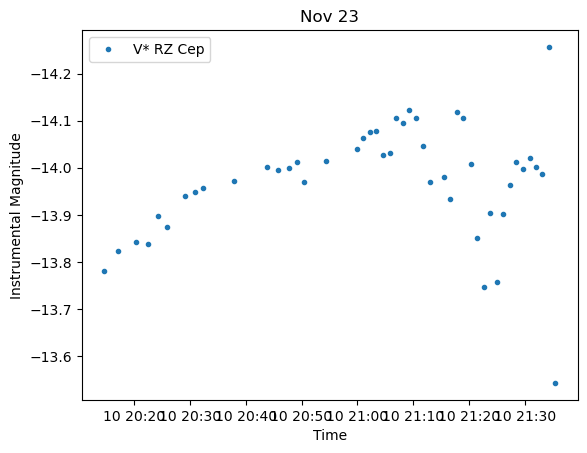

In [100]:
date_times = pd.to_datetime(date_time_array)

errors = np.asarray(errors)
#print(errors)
#err_stan = np.asarray(err_stan)
corrected_mags = np.asarray(corrected_mags)
#print(corrected_mags)
#corr_stan = np.asarray(corr_stan)

# stan_1 = np.asarray(stan_1)
# stan_2 = np.asarray(stan_2)
# stan_3 = np.asarray(stan_3)
# stan_4 = np.asarray(stan_4)
# stan_5 = np.asarray(stan_5)
# print(len(date_time_array))
# print(len(stan_1))
#plt.errorbar(date_times, corrected_mags, yerr=errors, marker='.', ls='None', label='V* RZ Cep')
plt.plot(date_times, corrected_mags, marker='.', ls='None', label='V* RZ Cep')
# plt.plot(date_times, stan_1, marker='.', ls='None', label='TYC 4273-435-1')
# plt.plot(date_times, stan_2, marker='.', ls='None', label='TYC 4273-1186-1')
# plt.plot(date_times, stan_3, marker='.', ls='None', label='TYC 4273-922-1')
# plt.plot(date_times, stan_4, marker='.', ls='None', label='TYC 4273-1038-1')
# plt.plot(date_times, stan_5, marker='.', ls='None', label='TYC 4273-1351-1')
plt.gca().invert_yaxis()
plt.legend()
if dataset_number == 1:
    plt.title('Dec 22')
elif dataset_number == 2:
    plt.title('Jan 23')
elif dataset_number == 3:
    plt.title('Feb 23')
elif dataset_number == 4:
    plt.title('Nov 23')
elif dataset_number == 5:
    plt.title('Zara Nov 22')
plt.xlabel('Time')
plt.ylabel('Instrumental Magnitude')
plt.show()

In [101]:
#use ap stats error or sqrt counts

df_curve = pd.DataFrame(data=(corrected_mags, errors, date_times, counts_aperture, counts_annulus, 
                              sky_subtracted_counts, aperture_radius, exp_time))
df_curve = df_curve.T
df_curve.columns = ['corrected_magnitude', 'magnitude_error', 'date_time', 'ap_counts', 'an_counts',
                   'sky_sub', 'radius', 'exp_time']
df_curve.to_csv(final_csv_path / final_csv_name)

# df_curve = pd.DataFrame(data=(corrected_mags, errors, date_times))
# df_curve = df_curve.T
# df_curve.columns = ['corrected_magnitude', 'magnitude_error', 'date_time']
# df_curve.to_csv(final_csv_path / final_csv_name)

# df_curve1 = pd.DataFrame(data=(corr_stan, err_stan, date_times))
# df_curve1 = df_curve1.T
# df_curve1.columns = ['corrected_magnitude', 'magnitude_error', 'date_time']
# df_curve1.to_csv(final_csv_path / 'stan_nov.csv')

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
C:\Users\local_es2143\Temp\ipykernel_18208\3144995306.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('hsv')


43


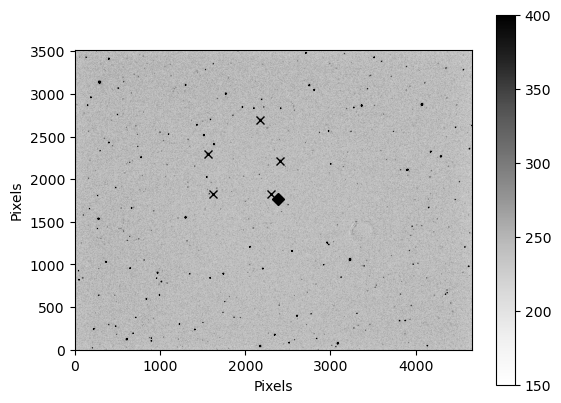

['V* RZ Cep', 'TYC 4273-1351-1', 'TYC 4273-435-1', 'UCAC4 774-052682', 'TYC 4273-884-1', 'BD+64  1700', 'LSPM J2241+6501', 'TYC 4273-668-1', 'TYC 4273-876-1', '2MASS J22405245+6505370', 'IRAS 22364+6432', 'IRAS 22404+6450', '2MASS J22365043+6456254', 'Gaia DR3 2212402667093547008', 'UCAC4 776-050735', 'GSH 109+06-32', '2MASS J22420892+6508103', 'TYC 4273-922-1', 'TYC 4273-149-1', 'Ross  214', 'UCAC4 776-050768', 'TYC 4273-609-1', 'TYC 4273-343-1', 'TYC 4273-307-1', 'Gaia DR2 2211637677581574144', '1RXS J223959.9+643330', 'Gaia DR3 2211625479874273536', 'TYC 4273-858-1', 'Gaia DR3 2212396207462733568', 'UCAC4 776-050859', 'UCAC4 774-052557', 'TYC 4273-1038-1', 'TYC 4273-1022-1', 'Gaia DR2 2211583698432680064', 'TYC 4273-822-1', 'TYC 4273-659-1', 'TYC 4273-673-1', 'TYC 4273-695-1', 'TYC 4273-1186-1', 'NVSS J224004+645852', 'Gaia DR3 2211625484173740928', 'TYC 4273-293-1', 'NVSS J224054+645420']


In [22]:
from astropy.nddata import CCDData
import matplotlib.cm

path_stars = Path(f'./RZ Cep/All_RZ_Cep/2022_12_07/RZ_Cep/CSVs/Normalised')
file_list_2 = [f for f in os.listdir(path_stars)if f.endswith('.csv')]
lent = len(file_list_2) - 1
stars_nov = pd.read_csv(path_stars / file_list_2[1])

positions = []
names = []
for idx, row in stars_nov.iterrows():
    positions.append([float(row[x_pos_name]), float(row[y_pos_name])])
    names.append(str(row['star_id']))
    
ref_im = CCDData.read(f'./RZ Cep/All_RZ_Cep/2022_12_07/RZ_Cep/Lights/Luminance Reduced/star_Light_Luminance_5_secs_002_reduced.fits')

cmap=plt.cm.get_cmap('hsv')
norm = plt.Normalize(0, len(names))
names_arr = []
print(len(names))
for i in range(len(names)):
#     plt.plot(positions[i][0], positions[i][1], marker='.', color=cmap(norm(i)), ls='None')
    names_arr.append(names[i])
# , label=names[i]

# j = 33
plt.plot(positions[0][0], positions[0][1], marker='D', color='k')
plt.plot(positions[6][0], positions[6][1], marker='x', color='k')
plt.plot(positions[5][0], positions[5][1], marker='x', color='k')
plt.plot(positions[15][0], positions[15][1], marker='x', color='k')
plt.plot(positions[30][0], positions[30][1], marker='x', color='k')
plt.plot(positions[33][0], positions[33][1], marker='x', color='k')
#plt.plot(positions[3][0], positions[3][1], marker='x', color='k', label=names[3])
#plt.plot(positions[36][0], positions[36][1], marker='x', color='k', label=names[36])
#plt.plot(positions[27][0], positions[27][1], marker='x', color='k', label=names[27])
#plt.plot(positions[16][0], positions[16][1], marker='x', color='k', label=names[16])
plt.imshow(ref_im.data, cmap='Greys', vmin=150, vmax=400)
plt.gca().invert_yaxis()
plt.colorbar()
plt.xlabel('Pixels')
plt.ylabel('Pixels')
# plt.legend()
plt.show()
print(names_arr)
# star_list = ['BD+64  1700', 'LSPM J2241+6501', 'GSH 109+06-32', 'UCAC4 774-052557', 'Gaia DR2 2211583698432680064']

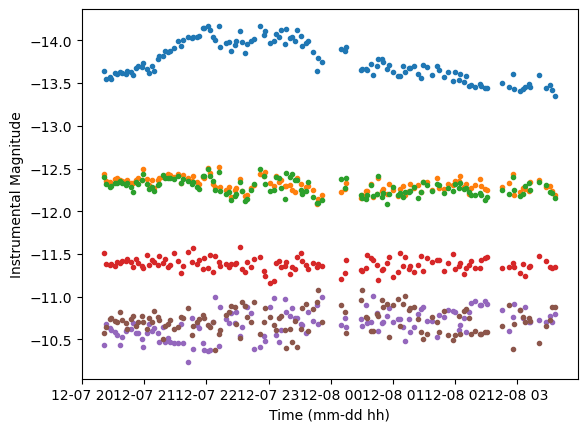

In [32]:
path_stars = Path(f'./RZ Cep/All_RZ_Cep/2022_12_07/RZ_Cep/CSVs/Normalised')
file_list_2 = [f for f in os.listdir(path_stars)if f.endswith('.csv')]

mag_rz = []
mag_star1 = []
mag_star2 = []
mag_star3 = []
mag_star4 = []
mag_star5 = []
time_stars = []

for i in range(len(file_list_2)):
    df = pd.read_csv(path_stars / file_list_2[i])
    mag_rz_ = df.loc[df['star_id'] == 'V* RZ Cep']['normalised_mag']
    mag_star1_ = df.loc[df['star_id'] == 'BD+64  1700']['normalised_mag']
    mag_star2_ = df.loc[df['star_id'] == 'LSPM J2241+6501']['normalised_mag']
    mag_star3_ = df.loc[df['star_id'] == 'GSH 109+06-32']['normalised_mag']
    mag_star4_ = df.loc[df['star_id'] == 'UCAC4 774-052557']['normalised_mag']
    mag_star5_ = df.loc[df['star_id'] == 'Gaia DR2 2211583698432680064']['normalised_mag']
    
    if len(mag_rz_) == 0:
        continue
    if len(mag_star1_) == 0:
        continue
    if len(mag_star2_) == 0:
        continue
    if len(mag_star3_) == 0:
        continue
    if len(mag_star4_) == 0:
        continue
    if len(mag_star5_) == 0:
        continue
        
    mag_rz.append(float(mag_rz_))
    mag_star1.append(float(mag_star1_))
    mag_star2.append(float(mag_star2_))
    mag_star3.append(float(mag_star3_))
    mag_star4.append(float(mag_star4_))
    mag_star5.append(float(mag_star5_))
    time_stars.append(df['date_time'][0])
    
date_time_stars = pd.to_datetime(time_stars)
plt.plot(date_time_stars, mag_rz, marker='.', ls='None')
plt.plot(date_time_stars, mag_star1, marker='.', ls='None')
plt.plot(date_time_stars, mag_star2, marker='.', ls='None')
plt.plot(date_time_stars, mag_star3, marker='.', ls='None')
plt.plot(date_time_stars, mag_star4, marker='.', ls='None')
plt.plot(date_time_stars, mag_star5, marker='.', ls='None')
plt.gca().invert_yaxis()
plt.xlabel('Time (mm-dd hh)')
plt.ylabel('Instrumental Magnitude')
plt.show()

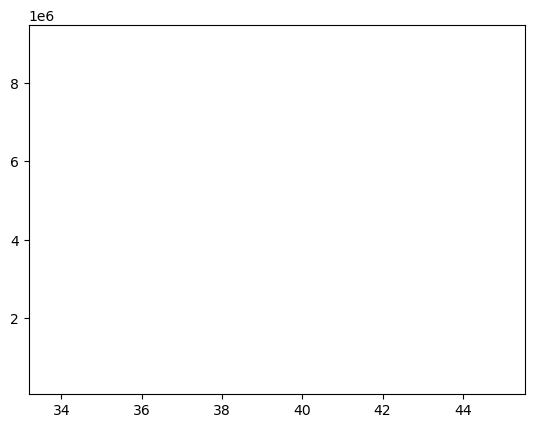

In [8]:
path_stars_2 = Path(f'./RZ Cep/All_RZ_Cep/2023_01_23/RZ_Cep/CSVs/Normalised')
file_list_3 = [f for f in os.listdir(path_stars_2)if f.endswith('.csv')]

counts_aperture = []
counts_annulus = []
sky_subtracted_counts = []
aperture_radius = []

for i in range(len(file_list_3)):
    df = pd.read_csv(path_stars_2 / file_list_3[i])
    counts_aperture.append(float(df.loc[df['star_id'] == 'V* RZ Cep']['counts']))
    counts_annulus.append(float(df.loc[df['star_id'] == 'V* RZ Cep']['annulus_bkg']))
    sky_subtracted_counts.append(float(df.loc[df['star_id'] == 'V* RZ Cep']['sky_corrected_counts']))
    aperture_radius.append(float(df.loc[df['star_id'] == 'V* RZ Cep']['FWHM']) * 3)
    
plt.plot(aperture_radius, counts_aperture, ls='None', label='Counts in Aperture')
plt.plot(aperture_radius, counts_annulus, ls='None', label='Counts in Annulus')
plt.plot(aperture_radius, sky_subtracted_counts, ls='None', label='Annulus Corrected Aperture Counts')
plt.show()